In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import jammy_flows
from cnn import SimpleCNN
from B03train_normalizing_flow_template import CombinedModel, nf_loss

Meander not installed... contours can not be calculated.


In [2]:
data_path = "data"
flow_type = "full_gaussian" # ["diagonal_gaussian", "full_gaussian", "full_flow"]
model_folder = "models/" + flow_type
plot_folder = "plots/" + flow_type
os.makedirs(model_folder, exist_ok=True)
os.makedirs(plot_folder, exist_ok=True)
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("CUDA version", torch.version.cuda)

Using cuda device
CUDA version 12.4


In [3]:
l0 = 4718 # angstrom, start of spectrum
l1 = 7890 # angstrom, end of spectrum
spectra = np.load(f"{data_path}/spectra.npy")
# normalize
spectra = np.log(np.maximum(spectra, 0.2))
spectra_length = spectra.shape[1]
# labels: mass, age, l_bol, dist, t_eff, log_g, fe_h, SNR
labelNames = ["mass", "age", "l_bol", "dist", "t_eff", "log_g", "fe_h", "SNR"]
labels = np.load(f"{data_path}/labels.npy")
# We only use the three labels: t_eff, log_g, fe_h
labelNames = labelNames[-4:-1]
labels = labels[:, -4:-1]
# normalize labels
label_means = np.mean(labels, axis=0)
label_stds = np.std(labels, axis=0)
labels = (labels - label_means) / label_stds
n_labels = labels.shape[1]

In [4]:
print(spectra)
print(type(spectra))
print(spectra.shape) # 8914, 16384 (number of spectra, length of each spectrum)

print(labelNames)
print(labels)
print(labels.shape)

[[-0.0182943  -0.01366498  0.00676046 ...  0.06692334  0.10649246
   0.20378247]
 [-0.04135376 -0.06643463 -0.11676109 ...  0.00545667  0.07043431
   0.20460529]
 [-0.07064897 -0.02532261 -0.01220473 ...  0.03334754  0.09973088
   0.2310698 ]
 ...
 [-0.02218651  0.00892046  0.01012168 ...  0.01696421  0.11753463
   0.2195622 ]
 [-0.1282717  -0.02985833  0.01431552 ...  0.00762445  0.06368124
   0.198687  ]
 [-0.03660118 -0.02355827 -0.01801771 ...  0.07393676  0.15408995
   0.2704637 ]]
<class 'numpy.ndarray'>
(8914, 16384)
['t_eff', 'log_g', 'fe_h']
[[ 0.49638405  0.62059     0.04494437]
 [ 0.58323914  0.2617865   1.2484009 ]
 [-0.69482577  0.87545943  0.0841229 ]
 ...
 [ 1.1606643   0.4199249  -0.12963866]
 [ 0.46888962  0.36218032 -0.85537946]
 [ 0.45096773  0.71121436 -0.76129895]]
(8914, 3)


### Visualize some spectra

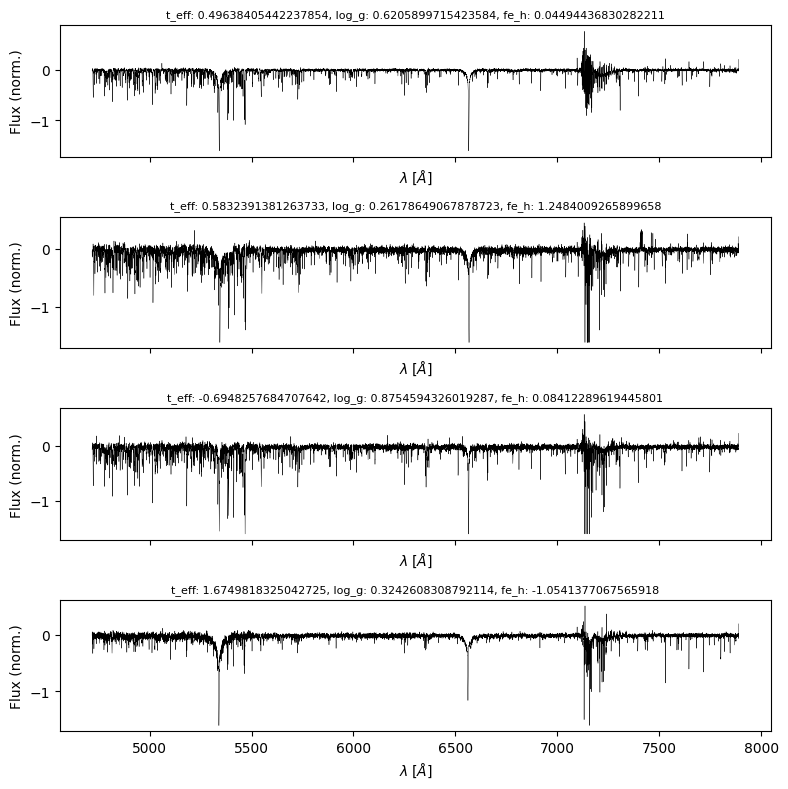

In [5]:
x = np.linspace(l0, l1, spectra_length)
fig, axs = plt.subplots(4, sharex=True, figsize=(8, 8))

for i in range(4):
    axs[i].plot(x, spectra[i], linewidth=0.3, color="black")
    axs[i].set_title(f"{labelNames[0]}: {labels[i, 0]}, {labelNames[1]}: {labels[i, 1]}, {labelNames[2]}: {labels[i, 2]}", fontsize=8)
    axs[i].set_ylabel("Flux (norm.)")
    axs[i].set_xlabel(r"$\lambda \; [Å]$")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "spectra.png"))

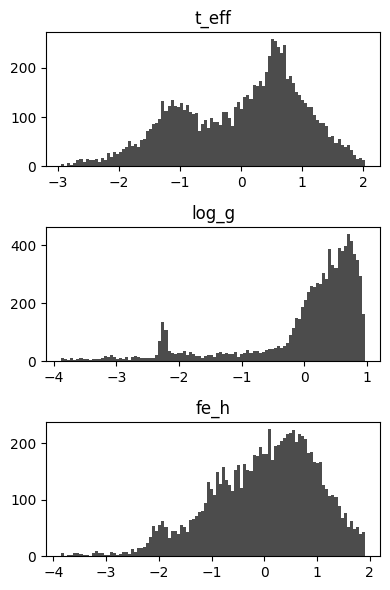

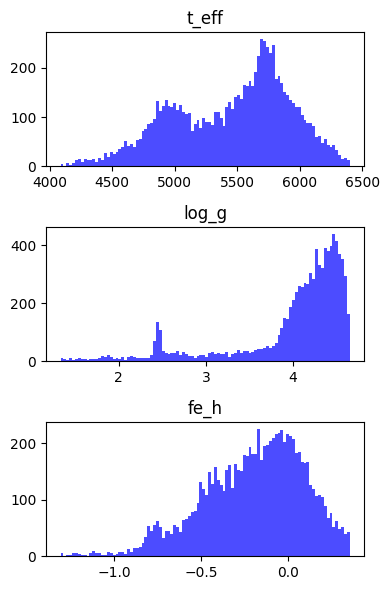

In [6]:
# visualize labels
fig, axs = plt.subplots(3, figsize=(4, 6))
for i in range(3):
    axs[i].hist(labels[:, i], bins=100, color="black", alpha=0.7)
    axs[i].set_title(labelNames[i])
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "labels_normalized.png"))

fig, axs = plt.subplots(3, figsize=(4, 6))
for i in range(3):
    reverse_normalized = labels[:, i] * label_stds[i] + label_means[i]
    axs[i].hist(reverse_normalized, bins=100, color="blue", alpha=0.7)
    axs[i].set_title(labelNames[i])
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "labels.png"))

### Create dataset and dataloader

In [7]:
####### DATASET #######
input_tensor = torch.Tensor(spectra).unsqueeze(1).to(device) # add dim for 1 channel
print(input_tensor)
print(input_tensor.shape)
labels_tensor = torch.Tensor(labels).to(device)

full_dataset = torch.utils.data.TensorDataset(input_tensor, labels_tensor)
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

####### DATA LOADER #######
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

tensor([[[-0.0183, -0.0137,  0.0068,  ...,  0.0669,  0.1065,  0.2038]],

        [[-0.0414, -0.0664, -0.1168,  ...,  0.0055,  0.0704,  0.2046]],

        [[-0.0706, -0.0253, -0.0122,  ...,  0.0333,  0.0997,  0.2311]],

        ...,

        [[-0.0222,  0.0089,  0.0101,  ...,  0.0170,  0.1175,  0.2196]],

        [[-0.1283, -0.0299,  0.0143,  ...,  0.0076,  0.0637,  0.1987]],

        [[-0.0366, -0.0236, -0.0180,  ...,  0.0739,  0.1541,  0.2705]]],
       device='cuda:0')
torch.Size([8914, 1, 16384])


### Create model and loss

In [8]:
model = CombinedModel(SimpleCNN, inputdim=spectra_length, nf_type=flow_type)
model.to(device)
print(model)
total_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable parameters", total_params)

####### LOSS AND OPTIMIZER #######

learning_rate = 0.8e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# models = {}
# optimizers = {}
# for flow_type in ["diagonal_gaussian", "full_gaussian", "full_flow"]:
#     models[flow_type] = CombinedModel(SimpleCNN, inputdim=spectra_length, nf_type=flow_type)

#     print(models[flow_type])
#     total_params = sum([p.numel() for p in models[flow_type].parameters() if p.requires_grad])
#     print("Trainable parameters", total_params)

#     ####### LOSS AND OPTIMIZER #######

#     learning_rate = 0.8e-5
#     optimizers[flow_type] = torch.optim.Adam(models[flow_type].parameters(), lr=learning_rate)


sub-manifold (0 - e3 - t) and intra-manifold flow (0 - t) options overwrite  cov_type  with  full
The normalizing flow has  9  parameters...
CombinedModel(
  (pdf): pdf(
    (layer_list): ModuleList(
      (0): ModuleList(
        (0): mvn_block()
      )
    )
    (mlp_predictors): ModuleList(
      (0): None
    )
  )
  (encoder): SimpleCNN(
    (conv1): Conv1d(1, 2, kernel_size=(4,), stride=(1,), padding=same)
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(2, 4, kernel_size=(4,), stride=(1,), padding=same)
    (fc1): Linear(in_features=4096, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=9, bias=True)
  )
)
Trainable parameters 533303


In [9]:
####### TRAIN #######
n_epochs = 400
print("Starting training loop with {} epochs".format(n_epochs))
train_losses = []
test_losses = []
best_test_loss = 99999999999
best_model = None
earlystop_counter = 0
earlystop_patience = 10
stop_now = False

for epoch in range(n_epochs):
    if stop_now:
        break
    start_time = time.time()
    train_loss = 0
    for i, (batch_input, batch_label) in enumerate(train_loader):
        model.train()
        # reset gradients
        optimizer.zero_grad()
        # propagate input
        output = model(batch_input)
        # compute loss
        loss = nf_loss(batch_input, batch_label, model)
        # compute gradient
        loss.backward()
        # update weights
        optimizer.step()
        # save loss
        train_loss += loss.item()
    ### END OF EPOCH ###
    # run validation
    with torch.no_grad():
        # val loss for the epoch
        test_loss = 0.0
        model.eval()  # Set the model to evaluation mode
        for batch_input, batch_label in test_loader:
            output = model(batch_input)
            loss = nf_loss(batch_input, batch_label, model)
            test_loss += loss.item()
        test_loss = test_loss/len(test_dataset)  # Calculate the average val loss
        test_losses.append(test_loss)
    # add losses
    train_loss = train_loss/len(train_dataset)  # Calculate the average train loss pe event
    train_losses.append(train_loss)
    end_time = time.time()
    if epoch % 10 == 0:
        # print progress
        print("Epoch", epoch, "train loss", train_loss, "test loss", test_loss, "time current epoch", end_time-start_time)
        # save model
        # model_path = os.path.join(model_folder, f"simpleCNN_epoch_{epoch}.pth")
        # torch.save(model.state_dict(), model_path)
        # plot loss
        plt.figure()
        plt.plot(train_losses, label="Train", linewidth=0.5)
        plt.plot(test_losses, label="Test", linewidth=0.5)
        plt.title("Astronomy CNN loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Event Loss")
        plt.yscale("log")
        plt.legend()
        plt.savefig(os.path.join(plot_folder, "loss.png"))
        plt.close()
    # EARLY STOPPING?
    if test_loss < best_test_loss:
        model_path = os.path.join(model_folder, "simpleCNN_best.pth")
        torch.save(model.state_dict(), model_path)
        best_model = model
        best_test_loss = test_loss
        earlystop_counter = 0
    else:
        earlystop_counter += 1
        if earlystop_counter > earlystop_patience:
            stop_now = True
            print("Early stopping at epoch", epoch, " with val loss", test_loss, " and best loss", best_test_loss)
            break

Starting training loop with 400 epochs


/home/axel/advanced-deep-learning-VT25/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 0 train loss 0.06578120925221895 test loss 0.06557445079255451 time current epoch 4.270524263381958
Epoch 10 train loss 0.06174782184289535 test loss 0.061819250334794275 time current epoch 2.036466598510742
Epoch 20 train loss 0.06020583771482586 test loss 0.06024082234143943 time current epoch 2.1352760791778564
Epoch 30 train loss 0.055991696596011914 test loss 0.05588678077415184 time current epoch 2.0811314582824707
Epoch 40 train loss 0.04571036826474441 test loss 0.045964817139168515 time current epoch 2.0496885776519775
Epoch 50 train loss 0.03871735656321617 test loss 0.03983901285563254 time current epoch 1.9346542358398438
Epoch 60 train loss 0.03583976074810852 test loss 0.037384737354068776 time current epoch 2.0292844772338867
Epoch 70 train loss 0.033826821985635205 test loss 0.03533821053777881 time current epoch 2.0950393676757812
Epoch 80 train loss 0.03211637132968785 test loss 0.03364476825786895 time current epoch 5.66656494140625
Epoch 90 train loss 0.030612

### Plot losses

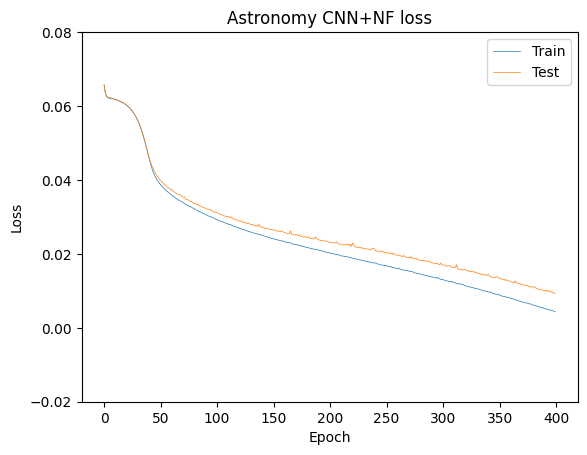

In [10]:
####### PLOT LOSS #######
plt.close()
plt.figure()
plt.plot(train_losses, label="Train", linewidth=0.5)
plt.plot(test_losses, label="Test", linewidth=0.5)
plt.title("Astronomy CNN+NF loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(-0.02, 0.08)
# plt.yscale("log")
plt.legend()
plt.savefig(os.path.join(plot_folder, "loss.png"))
plt.show()

### Open best model and plot some predictions

In [11]:

# model_path = os.path.join(model_folder, "simpleCNN_best.pth")
# model.load_state_dict(torch.load(model_path))
model = best_model

# predict on test
model.eval()
pred = []
true = []
pull = []
std = []
errors = []
relative_errors = []
first_batch = True
with torch.no_grad():
    for i, (batch_input, batch_label) in enumerate(test_loader):
        output = model(batch_input)
        preds = output[:, :n_labels]
        _std = output[:, n_labels:]
        error = (preds - batch_label)
        _pull = error / _std
        # reverse normalization
        # error = error.cpu() * label_stds + label_means
        # batch_label = batch_label.cpu() * label_stds + label_means
        relative_error = error / batch_label
        # append
        true.append(batch_label)
        pred.append(preds)
        pull.append(_pull)
        std.append(_std)
        errors.append(error)
        relative_errors.append(relative_error)
        if first_batch:
            model.visualize_pdf(batch_input, filename=os.path.join(plot_folder, "pdf_example.png"))
            first_batch = False

true = torch.cat(true, dim=0).cpu().numpy()
pred = torch.cat(pred, dim=0).cpu().numpy()
errors = torch.cat(errors, dim=0).cpu().numpy()
pull = torch.cat(pull, dim=0).cpu().numpy()
std = torch.cat(std, dim=0).cpu().numpy()
relative_errors = torch.cat(relative_errors, dim=0).cpu().numpy()

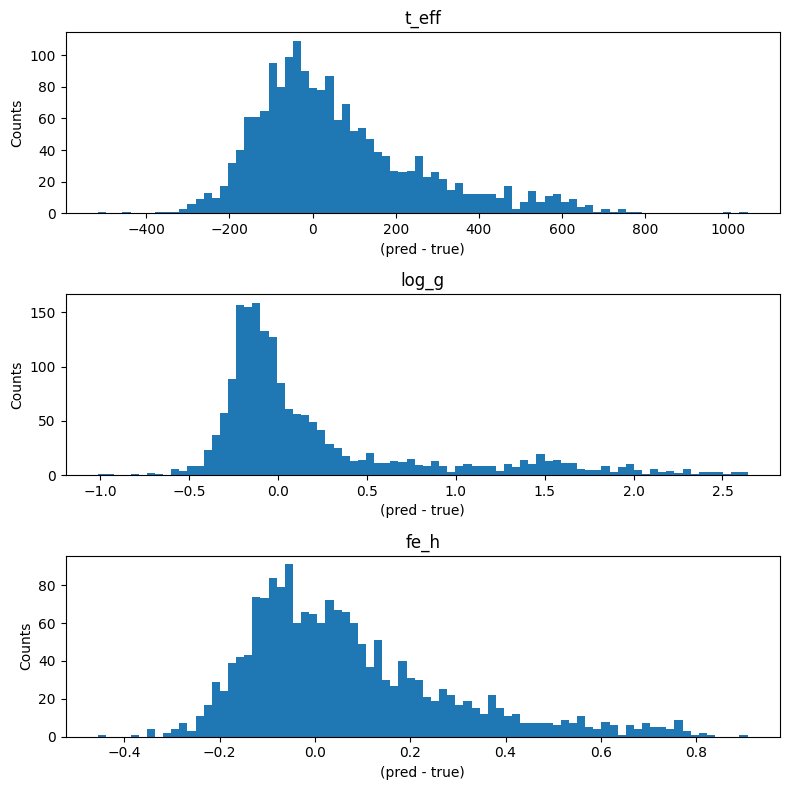

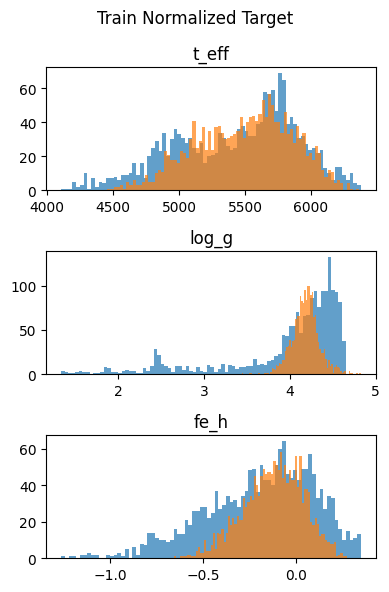

In [12]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
for i in range(3):
    axs[i].hist(errors[:, i] * label_stds[i], bins=80) # unnormalize (mean cancels, only need std)
    axs[i].set_title(labelNames[i])
    axs[i].set_xlabel("(pred - true)")
    axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred_errors.png"))

fig, axs = plt.subplots(3, figsize=(4, 6))
fig.suptitle("Train Normalized Target")
for i in range(3):
    axs[i].hist(true[:, i]* label_stds[i] + label_means[i], bins=80, alpha=0.7, label="True")
    axs[i].hist(pred[:, i]* label_stds[i] + label_means[i], bins=80, alpha=0.7, label="Pred")
    axs[i].set_title(labelNames[i])
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred.png"))

plt.show()

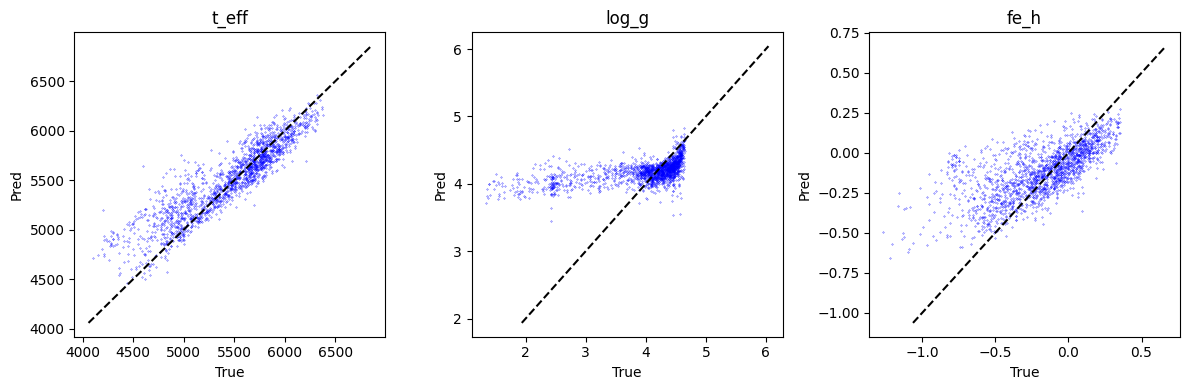

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# fig.suptitle("Predictions vs. True")
for i in range(3):
    axs[i].plot(true[:, i]* label_stds[i] + label_means[i], pred[:, i]* label_stds[i] + label_means[i], 'b.', markersize=0.5)
    axs[i].plot([label_means[i]-3*label_stds[i], label_means[i]+3*label_stds[i]], [label_means[i]-3*label_stds[i], label_means[i]+3*label_stds[i]], 'k--')
    axs[i].set_title(labelNames[i])
    axs[i].set_xlabel("True")
    axs[i].set_ylabel("Pred")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pred_vs_true.png"))


Gaussian fit parameters [ 7.19731981e+01 -1.54266035e-02 -9.76878274e-01]
Gaussian fit parameters [71.56818449 -0.24660428  0.94104925]
Gaussian fit parameters [7.01542750e+01 1.55310389e-02 1.01471961e+00]


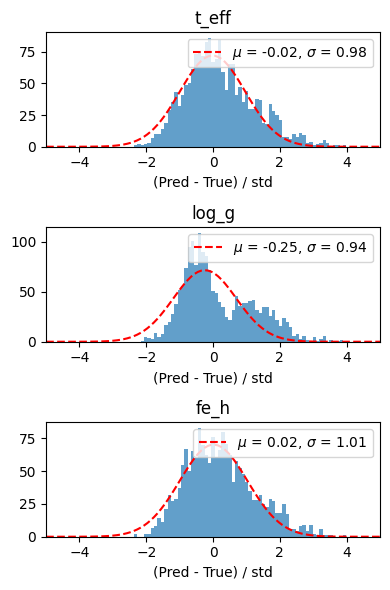

In [14]:
from scipy.optimize import curve_fit

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

xplot = np.linspace(-5, 5, 100)

# visualize pull
fig, axs = plt.subplots(3, figsize=(4, 6))
bins = np.linspace(-5, 5, 100)
for i in range(3):
    n, bins, patches = axs[i].hist(pull[:, i], bins=bins, alpha=0.7)
    # gaussian fit 
    popt, pcov = curve_fit(gauss_function, bins[:-1], n, p0=[1, 0, 1])
    mu = popt[1]
    sigma = popt[2]
    print("Gaussian fit parameters", popt)
    axs[i].plot(xplot, gauss_function(xplot, *popt), 'r--', label=r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mu, abs(sigma)))
    axs[i].set_title(labelNames[i])
    axs[i].set_xlabel("(Pred - True) / std")
    axs[i].set_xlim(-5, 5)
    axs[i].legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_folder, "pull.png"))